In [37]:
import json
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

In [38]:
def writeEvalsToFile(EVAL_PATH, RESULTS_PATH):
    files = glob.glob(os.path.join(EVAL_PATH, '*.json'), recursive=True)
    complete_results = []
    
    for path in files:
        # print(path) 
        results_file = open(os.path.join(RESULTS_PATH, f"{path.split('/')[-1]}"), 'w')
        results = {}
        check_file = os.path.getsize(path)

        if check_file == 0:
            continue
                
        with open(path, 'r') as file:
            
            evals = json.load(file)
            total_yes = 0
            total_no = 0
            unknown = 0
            
            for eval in evals:
                ground_truth = eval['ground_truth']
                answer_type = 'yes-no'
                consistent = eval['consistent'].split('consistent:')[-1]
                is_correct = "unknown"
                
                if 'yes' in consistent.lower() or 'true' in consistent.lower():
                    is_correct = "correct"
                    total_yes += 1
                elif 'no' in consistent.lower() or 'false' in consistent.lower():
                    is_correct = "incorrect"
                    total_no += 1
                else:
                    unknown += 1
    
                key = f"{answer_type}"
                if key in results.keys():
                        results[key][is_correct] += 1
                        results[key]['total'] += 1
                else:
                    results[key] = {'correct': 0, 'incorrect': 0, 'unknown': 0, 'total': 1}
                    results[key][is_correct] = 1
            
            results['yes'] = total_yes
            results['no'] = total_no
            results['unknown'] = unknown
            
            sorted_items = sorted(results.items(), key=lambda x: x[0])
            
            sorted_dict = dict(sorted_items)
    
            for key in ['yes-no', 'number', 'shape', 'size', 'relation', 'colour', 'material']:
                # print(key)
                if key in results.keys():
                    sorted_dict["accuracy_" + key] = results[key]['correct']/(results[key]['correct'] + results[key]['incorrect'])
            if total_yes + total_no > 0:
                sorted_dict["accuracy"] = results['yes']/(results['no']+results['yes'])
    

            json.dump(sorted_dict, results_file)
            results_file.close()
  
            # if total_yes + total_no > 0:
            #     print(total_yes, total_no, unknown, total_yes/(total_yes+total_no))

In [39]:
def showEvalsPlotOver_( mllm, comparison = 'num'):
    lang_augmentations = ['orig', 'and', 'or', 'not', 'complex']
    results = [[] for _ in range(5)]

    if comparison == 'num':
        iterate = range(3,11)
    elif comparison == 'type':
        iterate = ['inter', 'intra']
    else:
        return
    
    for i in iterate:
        for idx, aug in enumerate(lang_augmentations):
            with open(f"{RESULTS_PATH}/val_{comparison}_{i}_{aug}.json", 'r') as file:
                data = json.load(file)    
                results[idx].append(data)
    
    x = iterate

    plt.figure(figsize=(8, 6))
    for idx, aug in enumerate(lang_augmentations):
        plt.plot(x, [res['accuracy'] for res in results[idx]], marker='o', label=f'accuracy_{aug}')
    
    plt.xlabel('Object')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Variation over Objects ({mllm})')
    
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f'{RESULTS_PATH}/plot_{comparison}.png')
    plt.show()

-------PLOTS FOR LLaVA-------


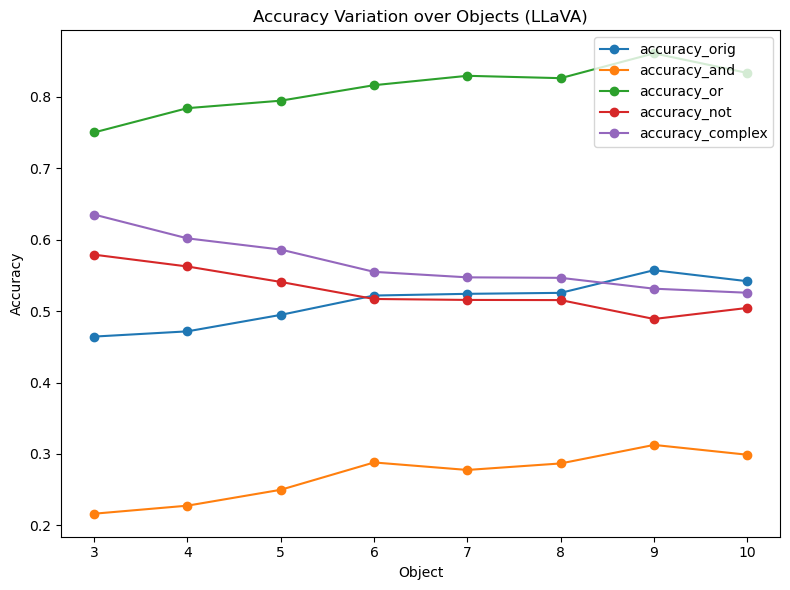

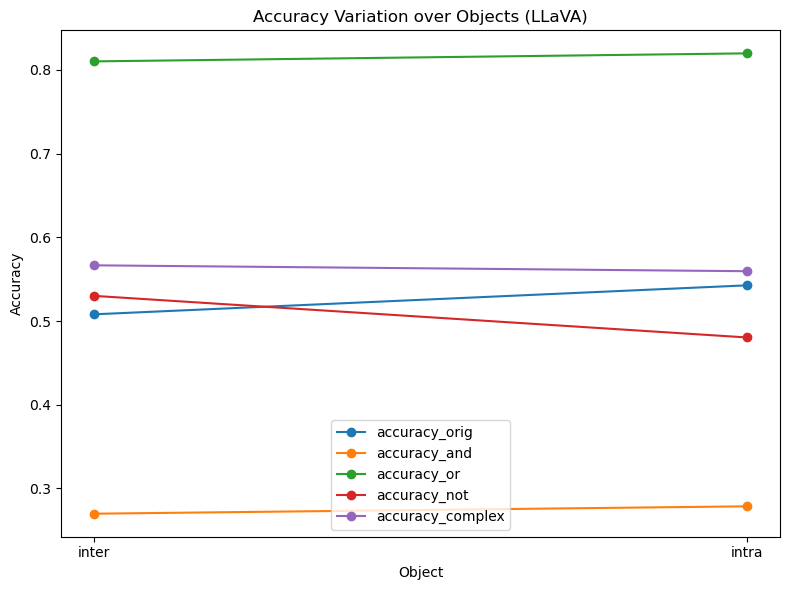

-------PLOTS FOR LLaMA-------


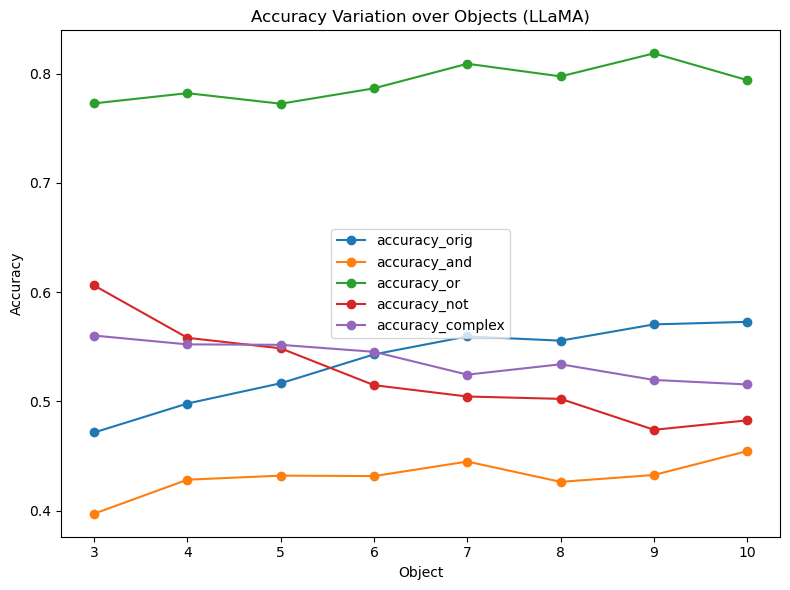

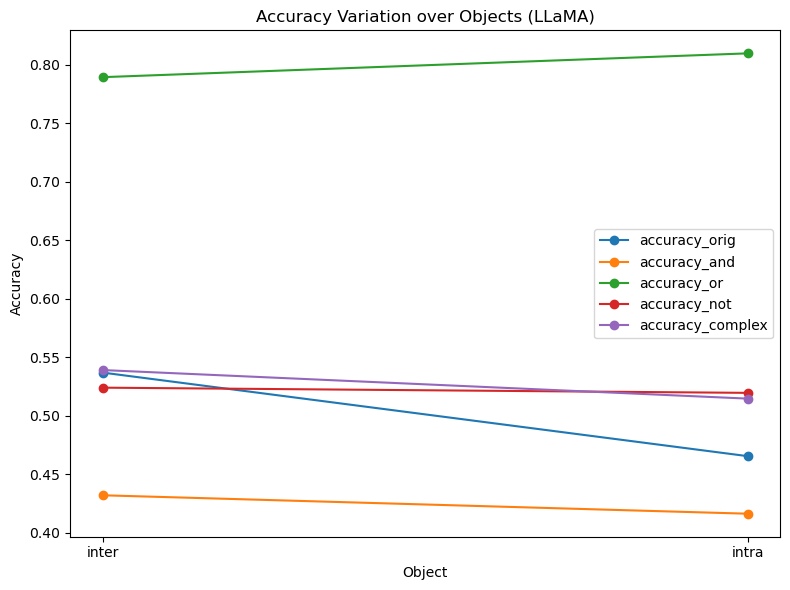

-------PLOTS FOR InstructBLIP-------


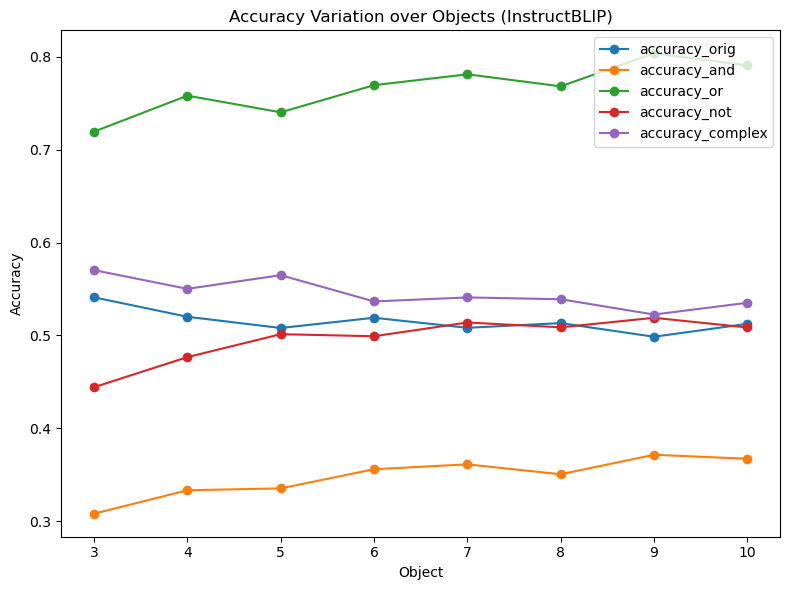

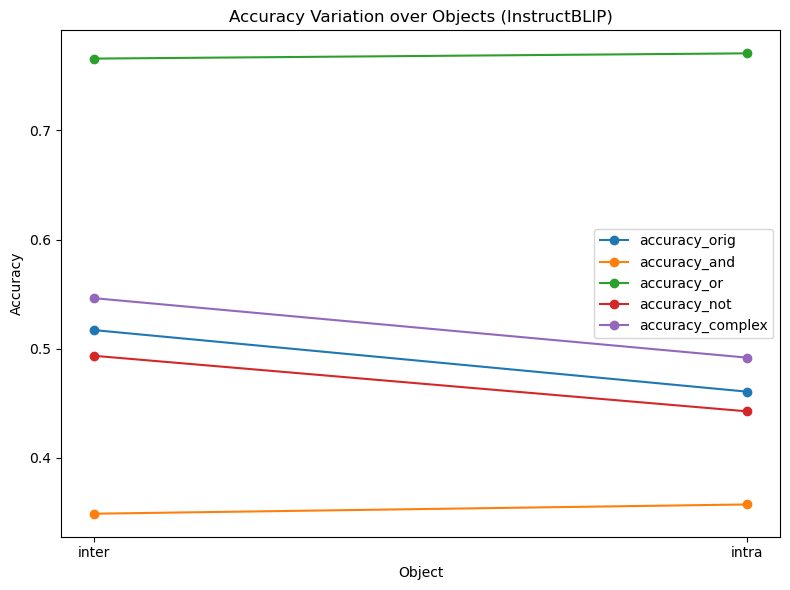

In [41]:
MLLM_LIST = ['LLaVA', 'LLaMA', 'InstructBLIP']

for mllm in MLLM_LIST:
    EVAL_PATH = f'/scratch/averma90/MLLM_Hallucinations_CLEVR/outputs/language_augmentation/Zephyr_Results/{mllm}'  
    RESULTS_PATH = f'/scratch/averma90/MLLM_Hallucinations_CLEVR/outputs/language_augmentation/Zephyr_Analysis/{mllm}'
    
    writeEvalsToFile(EVAL_PATH, RESULTS_PATH)
    print(f'-------PLOTS FOR {mllm}-------')
    showEvalsPlotOver_(mllm,'num')
    showEvalsPlotOver_(mllm, 'type')